In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

Step 2：将Excel策略升级为Benchmark策略，做以下三点：	
	1. 包含data页里的所有品种，而不是仅仅两个
	2. 统一从2017年开始回测
	3. 遍历回归样本长度的参数，取值26:26:182
	step2他这次的要求是说还是统一从2017开始回测所有品种，然后重点是要计算出夏普率并且做个表格

In [2]:
### 数据清洗
date = pd.read_excel(r"C:\Users\lll23\Documents\WXWork\1688857525503677\Cache\File\2024-03\Workshop_backtest(1).xlsx",sheet_name="Data")
data = date.iloc[207:]

In [3]:
data = data.drop(date.index[-1])

In [4]:
####用0填充缺失值，为0时回归不考虑该因素
data = data.fillna(0)

In [ ]:
#### 定义回测函数，输入特征值和标签列，返回标签，标签为所有行的和，
def model(x,y,test):
    # 创建线性回归模型
    model = LinearRegression()
    # 拟合模型
    model.fit(x, y)
    pre = model.predict(np.array(test).reshape(1,-1))[0]
    return pre,np.sign(pre)

In [6]:
####分组回测，按26分组，依次输入进行回测,数据总共有300行，分11次迭代进行回测
data_nd = data.iloc[:,1:]
result = []
for i in range(11):
    if i==10:
        for j in range(14):
            x = data_nd.iloc[i*26+j:((i+1)*26+j)]
            y = data_nd.iloc[i*26+1+j:((i+1)*26+j+1)].sum(axis=1)
            test = data_nd.iloc[(i+1)*26+j]
            pre,sign = model(x,y,test)
            result.append([test.sum(),pre,sign])
    else:    
       for j in range(26):
            x = data_nd.iloc[i*26+j:((i+1)*26+j)]
            y = data_nd.iloc[i*26+1+j:((i+1)*26+j+1)].sum(axis=1)
            test = data_nd.iloc[(i+1)*26+j]
            pre,sign = model(x,y,test) 
            result.append([test.sum(),pre,sign])

c:\Users\lll23\Anaconda3\envs\skl\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\lll23\Anaconda3\envs\skl\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\lll23\Anaconda3\envs\skl\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\lll23\Anaconda3\envs\skl\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\lll23\Anaconda3\envs\skl\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\lll23\Anaconda3\envs\skl\lib\site-pa

In [7]:
result = np.array(result)

In [8]:
WeeklyReturn = np.concatenate(([None], result[1:,0]*result[:-1,2]))

In [9]:
CumulativeReturn = [None]
for i in range(1,len(WeeklyReturn)):
    CumulativeReturn.append(np.sum(WeeklyReturn[1:i+1]))

In [10]:
result_end = np.concatenate((result,WeeklyReturn.reshape(-1,1),np.array(CumulativeReturn).reshape(-1,1)), axis=1)

In [11]:
result_end = pd.DataFrame(result_end,columns=["y_sum","Predict","Position","WeeklyReturn","CumulativeReturn"],index=np.array(data.iloc[26:-1,0]))

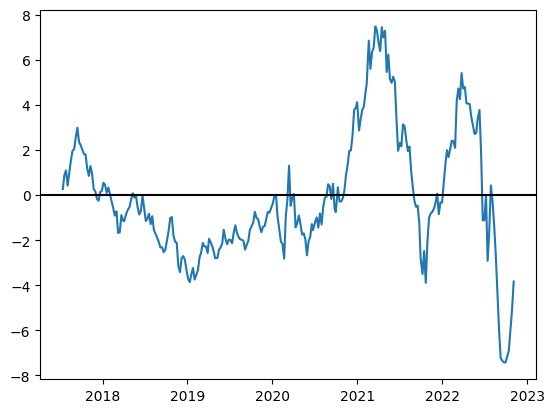

In [12]:
plt.plot(result_end.index[1:],result_end.iloc[1:,4])
plt.axhline(y=0, color='black', linestyle='-')  

In [13]:
result_end.to_excel(r"C:\Users\lll23\Desktop\应用\数据分析\实战\plt_date\ddd.xlsx",index_label=True)

In [14]:
###计算每列数据的夏普比,无风险利率按银行年化利率1.75%计算
df = data.iloc[:-1,1:]
xpb = (df.sum()-0.0175*5)/df.std()
xpb.to_excel('xpb_17_22.xlsx', header=['夏普率'], index=True)

Step 3: 在Benchmark基础上改进策略，以提高策略的夏普比	
	1. 改进策略的方向可以为增加自变量，需要逐步增加自变量，以清晰考察每个自变量是否提高夏普比
	2. 下节课课前上交一份基于word的报告，包含模型的文字描述和模型的回测结果，对于每一版本的模型需要有清晰的编号
	3. 展示结果时不要用表格，而是用图，一个参数画折线图，两个参数画热力图


In [15]:
####计算每列数据的夏普比,假定无风险利率为0时，
# df = date.iloc[:-1,1:]
# xpb = df.sum()/df.std()

In [16]:
###挑选所有期权
df = date.iloc[:-1,1:]
date_t = df.iloc[207:-1]
date_t = date_t.fillna(0)

In [17]:
#### 定义回测函数，输入特征值和标签列，返回标签，标签为所有行的和，
def model(x,y,test):
    # 创建线性回归模型
    model = LinearRegression()
    # 拟合模型
    model.fit(np.array(x).reshape(-1,1), y)
    pre = model.predict(np.array(test).reshape(-1,1))[0]
    return pre,np.sign(pre)

In [18]:
####分组回测，按26分组，依次输入进行回测,数据总共有300行，分11次迭代进行回测,对每一列数据进行回归
result = []
for i in range(11):
    if i==10:
        for j in range(14):
            ddd = []
            for c in  range(len(date_t.columns)):
                x = date_t.iloc[i*26+j:((i+1)*26+j),c]
                y = date_t.iloc[i*26+1+j:((i+1)*26+j+1),c]
                test = date_t.iloc[(i+1)*26+j]
                pre,sign = model(x,y,test)
                ddd += [test.sum(),pre,sign]
            result.append(ddd)
    else:    
       for j in range(26):
            ddd = []
            for c in  range(len(date_t.columns)):
                x = date_t.iloc[i*26+j:((i+1)*26+j),c]
                y = date_t.iloc[i*26+1+j:((i+1)*26+j+1),c]
                test = date_t.iloc[(i+1)*26+j,c]
                pre,sign = model(x,y,test)
                ddd += [test.sum(),pre,sign]
            result.append(ddd)    

In [19]:
result = np.array(result)
all_end = pd.DataFrame(data.iloc[26:-1,0])
for c in  range(47):
    WeeklyReturn = np.concatenate(([None], result[1:,3*c]*result[:-1,2+3*c]))
    CumulativeReturn = [None]
    for i in range(1,len(WeeklyReturn)):
        CumulativeReturn.append(np.sum(WeeklyReturn[1:i+1]))
    all_end[date_t.columns[c]] = CumulativeReturn

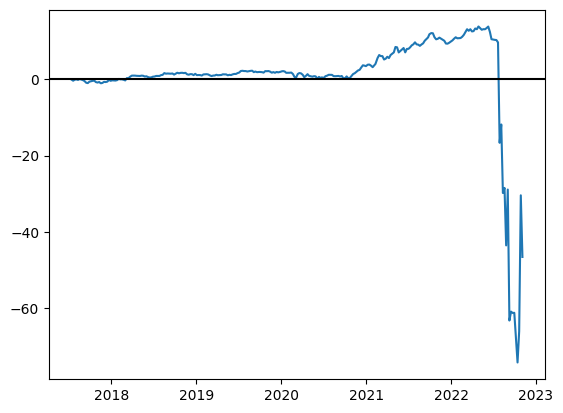

In [20]:
###选取所有期权等权重进行投资时的累计收益
plt.plot(all_end.iloc[1:,0],all_end.iloc[1:,1:].sum(axis=1))
plt.axhline(y=0, color='black', linestyle='-')

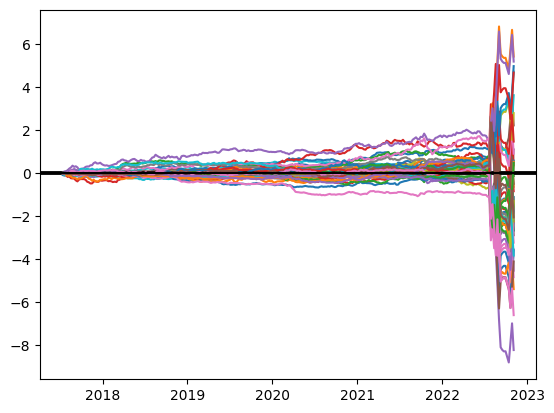

In [21]:
###选取所有期权进行投资时的累计收益
for j in range(1,len(all_end.columns)):
    plt.plot(all_end.iloc[1:,0],all_end.iloc[1:,j])
    plt.axhline(y=0, color='black', linestyle='-')  

In [22]:
####挑选出累计收益大于0的期权
lj_sy = all_end[all_end.columns[1:][all_end.iloc[:,1:].sum()>0]]

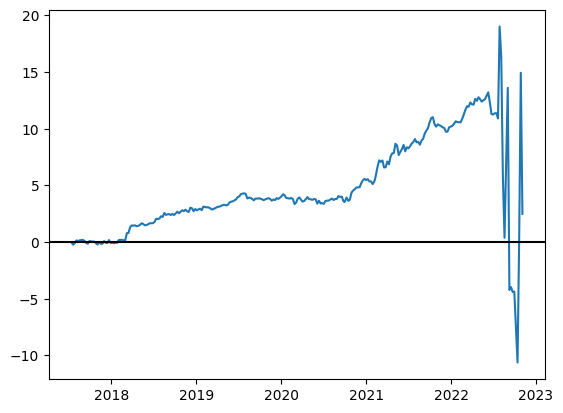

In [23]:
### 均等投资对所有累计收益大于0的期权的收益
plt.plot(all_end.iloc[1:,0],lj_sy.iloc[1:,1:].sum(axis=1))
plt.axhline(y=0, color='black', linestyle='-')

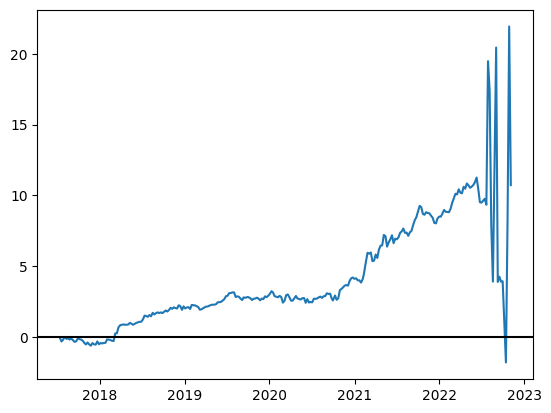

In [24]:
c = list(lj_sy.columns)
c.remove("j")
plt.plot(all_end.iloc[1:,0],lj_sy[c].iloc[1:,1:].sum(axis=1))
plt.axhline(y=0, color='black', linestyle='-')

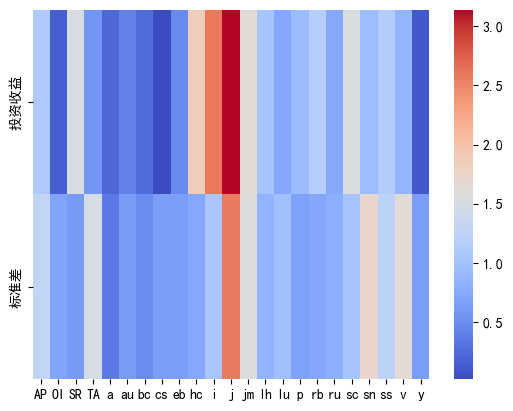

In [25]:
# 创建数据
# 绘制热力图,对于累计收益大于0的列
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题
mmm = lj_sy
sns.heatmap(pd.DataFrame([mmm.sum()/mmm.sum().mean(),mmm.std()/mmm.std().mean()],index=["投资收益","标准差"]), annot=False,cmap='coolwarm')
plt.show()

In [26]:
syb = pd.DataFrame(np.array(lj_sy.iloc[2:])-np.array(lj_sy.iloc[1:-1]),columns=lj_sy.columns)

In [27]:
xpb = syb.mean()/syb.std()

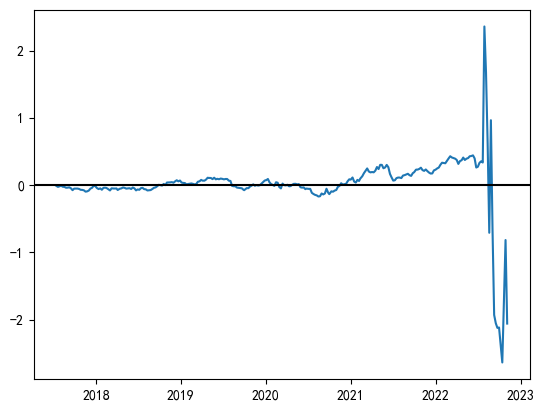

In [28]:
plt.plot(all_end.iloc[1:,0],lj_sy.iloc[1:,1:]["y"])
plt.axhline(y=0, color='black', linestyle='-')

In [29]:
lj_sy[lj_sy.columns[xpb>0]].iloc[1:,1:]

,SR,bc,lh,lu,p,sc,sn,ss,v
234,-0.008068,0.000000,0.000000,0.000000,-0.002451,0.000000,-0.006306,0.000000,-0.008159
235,-0.004441,0.000000,0.000000,0.000000,-0.019690,0.000000,0.008454,0.000000,0.037713
236,0.031836,0.000000,0.000000,0.000000,-0.034527,0.000000,-0.016196,0.000000,0.041831
237,0.008465,0.000000,0.000000,0.000000,-0.028089,0.000000,-0.011935,0.000000,0.119354
238,0.000351,0.000000,0.000000,0.000000,-0.032745,0.000000,-0.031273,0.000000,0.114903
...,...,...,...,...,...,...,...,...,...
502,1.083935,0.850553,2.853476,2.960232,1.414704,3.213260,5.374434,3.953348,5.139774
503,0.562373,0.328991,3.375038,3.481794,0.893142,3.734822,4.852872,3.431786,4.618212
504,1.471006,1.237624,2.466405,2.573161,1.801775,2.826189,5.761505,2.523153,5.526845
505,2.386079,2.152697,1.551332,3.488234,2.716848,3.741262,6.676578,3.438226,6.441918


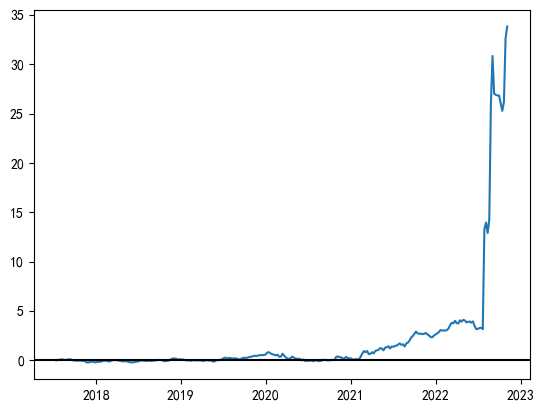

In [30]:
### 对xpb大于0的所有期权进行组合
plt.plot(all_end.iloc[1:,0],lj_sy[lj_sy.columns[xpb>0]].iloc[1:,1:].sum(axis=1))
plt.axhline(y=0, color='black', linestyle='-')

In [31]:
syb_22 = pd.DataFrame(np.array(lj_sy.iloc[-42:])-np.array(lj_sy.iloc[-43:-1]),columns=lj_sy.columns)
xpb_22 = syb_22.mean()/syb_22.std()

In [32]:
syb_q = pd.DataFrame(np.array(lj_sy.iloc[2:-42])-np.array(lj_sy.iloc[1:-43]),columns=lj_sy.columns)
xpb_q = syb_q.mean()/syb_q.std()

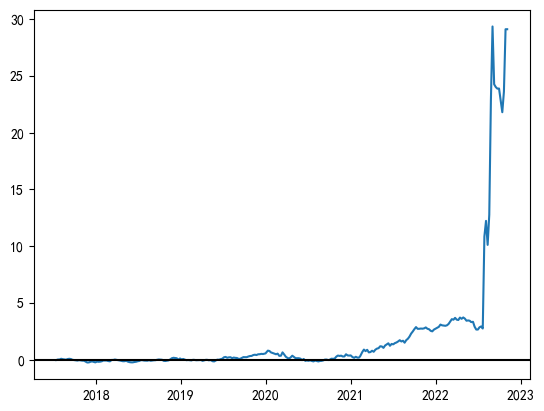

In [33]:
### 对xpb大于0的所有期权进行组合
plt.plot(all_end.iloc[1:,0],lj_sy[lj_sy.columns[(xpb_22>0) * (xpb_q>0)]].iloc[1:,1:].sum(axis=1))
plt.axhline(y=0, color='black', linestyle='-')

分别增加rt-1，rt平方，rt平方，momentent

$r_{t} and (r_{t}-r_{t-1})$

In [257]:
# ###挑选所有期权
# df = date.iloc[:-1,1:]
# date_t = df.iloc[206:]
# date_t = date_t.fillna(0)

In [18]:
###挑选所有期权,从16年下半年开始
df = date.iloc[:-1,1:]
date_t = df.iloc[181:]
date_t = date_t.fillna(0)

In [ ]:
dd = date_t.iloc[30:]
nofx_4week = 0.0175/13
for i in range(12):
    for j in range(len(date_t.columns)):
        date_xpl.iloc[j,i] = (dd.iloc[26*i:26*i+26,j].sum()-nofx_4week)/dd.iloc[26*i:26*i+26,j].std()

In [259]:
#### 定义回测函数，输入特征值和标签列，返回标签，标签为所有行的和，
def model(x,y,test):
    # 创建线性回归模型
    model = LinearRegression()
    # 拟合模型
    # print(x)
    model.fit(x, y)
    pre = model.predict(test)[0]
    return pre,np.sign(pre)

In [260]:
####分组回测，按26分组，依次输入进行回测,数据总共有300行，分11次迭代进行回测,对每一列数据进行回归
result = []
for i in range(12):
    if i==11:
        for j in range(14):
            ddd = []
            for c in  range(len(date_t.columns)):
                x = np.c_[np.array(date_t.iloc[i*26+j+1:((i+1)*26+j+1),c]),np.array(date_t.iloc[i*26+j+1:((i+1)*26+j+1),c])-np.array(date_t.iloc[i*26+j:((i+1)*26+j),c])]
                y = date_t.iloc[i*26+2+j:((i+1)*26+j+2),c]
                test = pd.DataFrame([[date_t.iloc[(i+1)*26+j+1,c],date_t.iloc[(i+1)*26+j+1,c]-date_t.iloc[(i+1)*26+j,c]]])
                pre,sign = model(x,y,test)
                ddd += [date_t.iloc[(i+1)*26+j+1,c],pre,sign]
            result.append(ddd)
    else:    
       for j in range(26):
            ddd = []
            for c in  range(len(date_t.columns)):
                x = np.c_[np.array(date_t.iloc[i*26+j+1:((i+1)*26+j+1),c]),np.array(date_t.iloc[i*26+j+1:((i+1)*26+j+1),c])-np.array(date_t.iloc[i*26+j:((i+1)*26+j),c])]
                y = date_t.iloc[i*26+2+j:((i+1)*26+j+2),c]
                test = pd.DataFrame([[date_t.iloc[(i+1)*26+j+1,c],date_t.iloc[(i+1)*26+j+1,c]-date_t.iloc[(i+1)*26+j,c]]])
                pre,sign = model(x,y,test)
                ddd += [date_t.iloc[(i+1)*26+j+1,c],pre,sign]
            result.append(ddd)

In [261]:
np.array(result).shape

(300, 141)

In [262]:
result = np.array(result)
all_end = pd.DataFrame(data.iloc[:-1,0])
for c in  range(47):
    WeeklyReturn = np.concatenate(([None], result[1:,3*c]*result[:-1,2+3*c]))
    CumulativeReturn = [None]
    for i in range(1,len(WeeklyReturn)):
        CumulativeReturn.append(np.sum(WeeklyReturn[1:i+1]))
    all_end[date_t.columns[c]] = CumulativeReturn

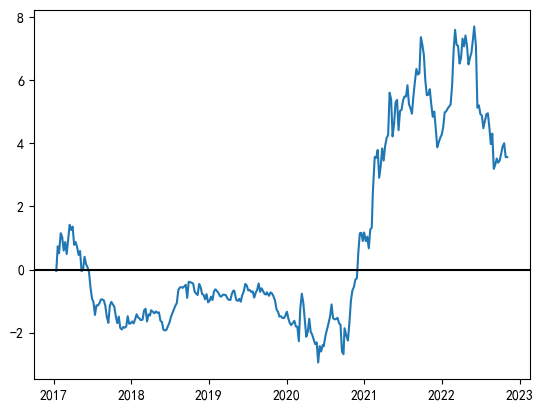

In [263]:
###选取所有期权等权重进行投资时的累计收益
plt.plot(all_end.iloc[1:,0],all_end.iloc[1:,1:].sum(axis=1))
plt.axhline(y=0, color='black', linestyle='-')

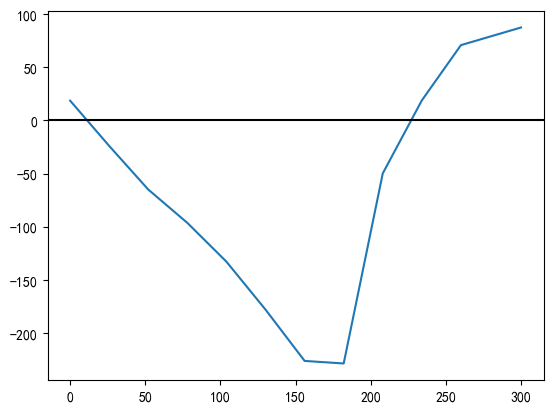

In [264]:
date_a = np.array(all_end.iloc[1:,1:].sum(axis=1))
label = [26*i for i in range(11)]
label.append(300)
date_xpl = np.zeros(12)
xpl = 0.175/2
for i in range(11):
    date_xpl[i] = date_a[:i*26+26].sum()/date_a[:i*26+26].std()
date_xpl[11] = date_a[:].sum()/date_a[:].std()
###选取所有期权等权重进行投资时的累计收益
plt.plot(label,date_xpl)
plt.axhline(y=0, color='black', linestyle='-')

$r_{t}andr_{t-1}$

In [249]:
# ###挑选所有期权
# df = date.iloc[:-1,1:]
# date_t = df.iloc[206:]
# date_t = date_t.fillna(0)

In [250]:
###挑选所有期权
df = date.iloc[:-1,1:]
date_t = df.iloc[181:]
date_t = date_t.fillna(0)

In [251]:
#### 定义回测函数，输入特征值和标签列，返回标签，标签为所有行的和，
def model(x,y,test):
    # 创建线性回归模型
    model = LinearRegression()
    # 拟合模型
    # print(x)
    model.fit(x, y)
    pre = model.predict(test)[0]
    return pre,np.sign(pre)

In [252]:
####分组回测，按26分组，依次输入进行回测,数据总共有300行，分11次迭代进行回测,对每一列数据进行回归
result = []
for i in range(12):
    if i==11:
        for j in range(14):
            ddd = []
            for c in  range(len(date_t.columns)):
                x = np.c_[np.array(date_t.iloc[i*26+j+1:((i+1)*26+j+1),c]),np.array(date_t.iloc[i*26+j:((i+1)*26+j),c])]
                y = date_t.iloc[i*26+2+j:((i+1)*26+j+2),c]
                test = pd.DataFrame([[date_t.iloc[(i+1)*26+j+1,c],date_t.iloc[(i+1)*26+j,c]]])
                pre,sign = model(x,y,test)
                ddd += [date_t.iloc[(i+1)*26+j+1,c],pre,sign]
            result.append(ddd)
    else:    
       for j in range(26):
            ddd = []
            for c in  range(len(date_t.columns)):
                x = np.c_[np.array(date_t.iloc[i*26+j+1:((i+1)*26+j+1),c]),np.array(date_t.iloc[i*26+j:((i+1)*26+j),c])]
                y = date_t.iloc[i*26+2+j:((i+1)*26+j+2),c]
                test = pd.DataFrame([[date_t.iloc[(i+1)*26+j+1,c],date_t.iloc[(i+1)*26+j,c]]])
                pre,sign = model(x,y,test)
                ddd += [date_t.iloc[(i+1)*26+j+1,c],pre,sign]
            result.append(ddd)

In [253]:
result = np.array(result)
all_end = pd.DataFrame(data.iloc[:-1,0])
for c in  range(47):
    WeeklyReturn = np.concatenate(([None], result[1:,3*c]*result[:-1,2+3*c]))
    CumulativeReturn = [None]
    for i in range(1,len(WeeklyReturn)):
        CumulativeReturn.append(np.sum(WeeklyReturn[1:i+1]))
    all_end[date_t.columns[c]] = CumulativeReturn

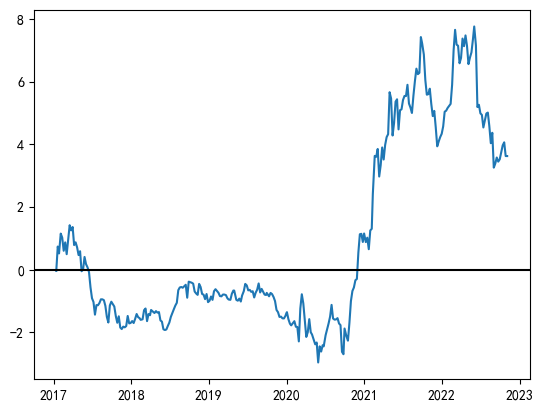

In [254]:
###选取所有期权等权重进行投资时的累计收益
plt.plot(all_end.iloc[1:,0],all_end.iloc[1:,1:].sum(axis=1))
plt.axhline(y=0, color='black', linestyle='-')

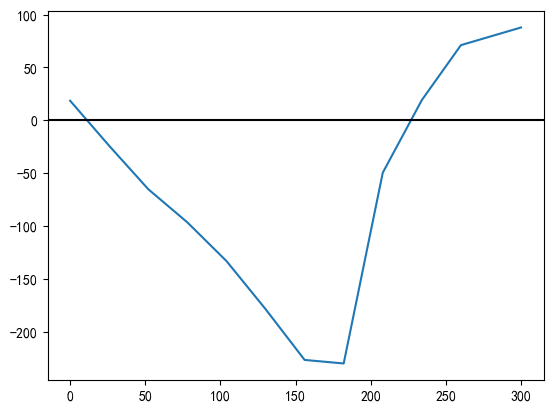

In [255]:
date_a = np.array(all_end.iloc[1:,1:].sum(axis=1))
label = [26*i for i in range(11)]
label.append(300)
date_xpl = np.zeros(12)
xpl = 0.175/2
for i in range(11):
    date_xpl[i] = date_a[:i*26+26].sum()/date_a[:i*26+26].std()
date_xpl[11] = date_a[:].sum()/date_a[:].std()
###选取所有期权等权重进行投资时的累计收益
plt.plot(label,date_xpl)
plt.axhline(y=0, color='black', linestyle='-')

$r_{t} and r_{t}^{2}$

In [239]:
###挑选所有期权
df = date.iloc[:-1,1:]
date_t = df.iloc[181:-1]
date_t = date_t.fillna(0)

In [240]:
#### 定义回测函数，输入特征值和标签列，返回标签，标签为所有行的和，
def model(x,y,test):
    # 创建线性回归模型
    model = LinearRegression()
    # 拟合模型
    # print(x)
    model.fit(x, y)
    pre = model.predict(test)[0]
    return pre,np.sign(pre)

In [241]:
####分组回测，按26分组，依次输入进行回测,数据总共有300行，分11次迭代进行回测,对每一列数据进行回归
result = []
for i in range(12):
    if i==11:
        for j in range(14):
            ddd = []
            for c in  range(len(date_t.columns)):
                x = np.array(pd.concat([date_t.iloc[i*26+j:((i+1)*26+j),c],date_t.iloc[i*26+j:((i+1)*26+j),c]**2],axis=1))
                # print(x)
                y = date_t.iloc[i*26+1+j:(i+1)*26+j+1,c]
                test = pd.DataFrame([[date_t.iloc[(i+1)*26+j,c],date_t.iloc[(i+1)*26+j,c]**2]])
                # print(test)
                pre,sign = model(x,y,test)
                ddd += [date_t.iloc[(i+1)*26+j,c],pre,sign]
            result.append(ddd)
    else:    
       for j in range(26):
            ddd = []
            for c in  range(len(date_t.columns)):
                x = pd.concat([date_t.iloc[i*26+j:((i+1)*26+j),c],date_t.iloc[i*26+j:((i+1)*26+j),c]**2],axis=1)
                y = date_t.iloc[i*26+1+j:((i+1)*26+j+1),c]
                test = pd.DataFrame([[date_t.iloc[(i+1)*26+j,c],date_t.iloc[(i+1)*26+j,c]**2]])
                pre,sign = model(x,y,test)
                ddd += [date_t.iloc[(i+1)*26+j,c],pre,sign]
            result.append(ddd)    

c:\Users\lll23\Anaconda3\envs\skl\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\lll23\Anaconda3\envs\skl\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\lll23\Anaconda3\envs\skl\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\lll23\Anaconda3\envs\skl\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\lll23\Anaconda3\envs\skl\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\lll23\Anaconda3\envs\skl\lib\site-pa

In [244]:
result = np.array(result)
all_end = pd.DataFrame(data.iloc[:-1,0])
for c in  range(47):
    WeeklyReturn = np.concatenate(([None], result[1:,3*c]*result[:-1,2+3*c]))
    CumulativeReturn = [None]
    for i in range(1,len(WeeklyReturn)):
        CumulativeReturn.append(np.sum(WeeklyReturn[1:i+1]))
    all_end[date_t.columns[c]] = CumulativeReturn

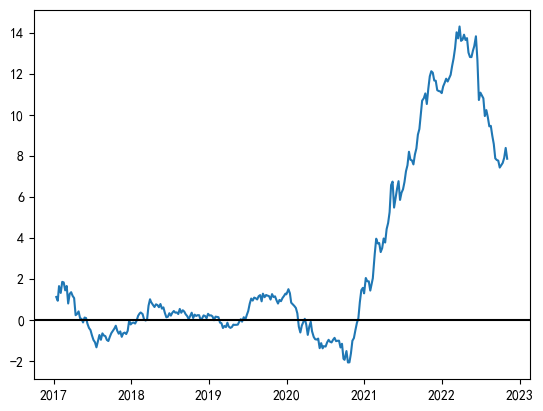

In [245]:
###选取所有期权等权重进行投资时的累计收益
plt.plot(all_end.iloc[1:,0],all_end.iloc[1:,1:].sum(axis=1))
plt.axhline(y=0, color='black', linestyle='-')

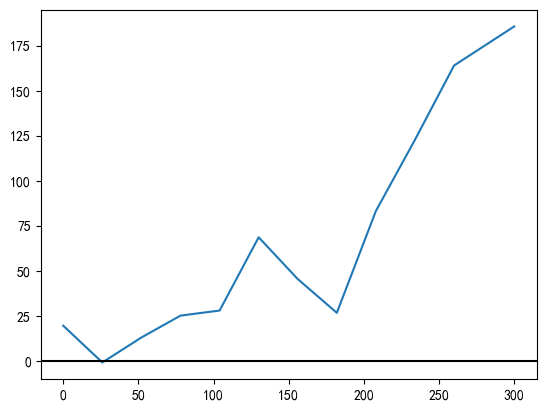

In [248]:
date_a = np.array(all_end.iloc[1:,1:].sum(axis=1))
label = [26*i for i in range(11)]
label.append(300)
date_xpl = np.zeros(12)
xpl = 0.175/2
for i in range(11):
    date_xpl[i] = date_a[:i*26+26].sum()/date_a[:i*26+26].std()
date_xpl[11] = date_a[:].sum()/date_a[:].std()
###选取所有期权等权重进行投资时的累计收益
plt.plot(label,date_xpl)
plt.axhline(y=0, color='black', linestyle='-')

momentum factor 动量因子策略

In [6]:
###挑选所有期权
df = date.iloc[:-1,1:]
date_t = df.iloc[177:-1]
date_t = date_t.fillna(0)

In [266]:
#### 定义回测函数，输入特征值和标签列，返回标签，标签为所有行的和，
def model(x,y,test):
    # 创建线性回归模型
    model = LinearRegression()
    # 拟合模型
    # print(x)
    model.fit(x, y)
    pre = model.predict(test)[0]
    return pre,np.sign(pre)

In [267]:
date_t.isnull().sum().sum()

0

In [269]:
i = 0
j = 4
x = pd.concat([date_t.iloc[i*26+j:((i+1)*26+j),c],(date_t.iloc[i*26+j-1:((i+1)*26+j-1),c]+date_t.iloc[i*26+j-2:((i+1)*26+j-2),c]+date_t.iloc[i*26+j-3:((i+1)*26+j-3),c]+date_t.iloc[i*26+j-4:((i+1)*26+j-4),c])/4],axis=1)

In [270]:
np.array(date_t.iloc[i*26+j-1:((i+1)*26+j-1),c])+np.array(date_t.iloc[i*26+j-2:((i+1)*26+j-2),c])+np.array(date_t.iloc[i*26+j-3:((i+1)*26+j-3),c])+np.array(date_t.iloc[i*26+j-4:((i+1)*26+j-4),c])

array([ 0.032508,  0.058566,  0.05165 ,  0.085641,  0.108763,  0.019917,
        0.054374,  0.022851,  0.010202,  0.059818,  0.06321 ,  0.039743,
        0.006292,  0.002998, -0.011938, -0.017026,  0.036336,  0.063807,
        0.081119,  0.163715,  0.14264 ,  0.193423,  0.130741,  0.08511 ,
        0.085629, -0.07397 ])

In [271]:
####分组回测，按26分组，依次输入进行回测,数据总共有300行，分11次迭代进行回测,对每一列数据进行回归
result = []
for i in range(12):
    if i==11:
        for j in range(14):
            ddd = []
            j = j+4
            for c in  range(len(date_t.columns)):
                x = np.c_[np.array(date_t.iloc[i*26+j:((i+1)*26+j),c]),np.array(date_t.iloc[i*26+j-1:((i+1)*26+j-1),c])+np.array(date_t.iloc[i*26+j-2:((i+1)*26+j-2),c])+np.array(date_t.iloc[i*26+j-3:((i+1)*26+j-3),c])+np.array(date_t.iloc[i*26+j-4:((i+1)*26+j-4),c])]
                y = date_t.iloc[i*26+1+j:((i+1)*26+j+1),c]
                test = pd.DataFrame([[date_t.iloc[(i+1)*26+j,c],(date_t.iloc[(i+1)*26+j-1,c]+date_t.iloc[(i+1)*26+j-2,c]+date_t.iloc[(i+1)*26+j-3,c]+date_t.iloc[(i+1)*26+j-4,c])/4]])
                # print(test)
                pre,sign = model(x,y,test)
                ddd += [date_t.iloc[(i+1)*26+j,c],pre,sign]
            result.append(ddd)
    else:    
       for j in range(26):
            j = j+4
            ddd = []
            for c in  range(len(date_t.columns)):
                x = np.c_[np.array(date_t.iloc[i*26+j:((i+1)*26+j),c]),np.array(date_t.iloc[i*26+j-1:((i+1)*26+j-1),c])+np.array(date_t.iloc[i*26+j-2:((i+1)*26+j-2),c])+np.array(date_t.iloc[i*26+j-3:((i+1)*26+j-3),c])+np.array(date_t.iloc[i*26+j-4:((i+1)*26+j-4),c])]
                y = date_t.iloc[i*26+1+j:((i+1)*26+j+1),c]
                # print(x)
                test = pd.DataFrame([[date_t.iloc[(i+1)*26+j,c],date_t.iloc[(i+1)*26+j-1,c]+date_t.iloc[(i+1)*26+j-2,c]+date_t.iloc[(i+1)*26+j-3,c]+date_t.iloc[(i+1)*26+j-4,c]]])
                pre,sign = model(x,y,test)
                ddd += [date_t.iloc[(i+1)*26+j,c],pre,sign]
            result.append(ddd)    

In [272]:
result = np.array(result)
all_end = pd.DataFrame(data.iloc[:-1,0])
for c in  range(47):
    WeeklyReturn = np.concatenate(([None], result[1:,3*c]*result[:-1,2+3*c]))
    CumulativeReturn = [None]
    for i in range(1,len(WeeklyReturn)):
        CumulativeReturn.append(np.sum(WeeklyReturn[1:i+1]))
    all_end[date_t.columns[c]] = CumulativeReturn

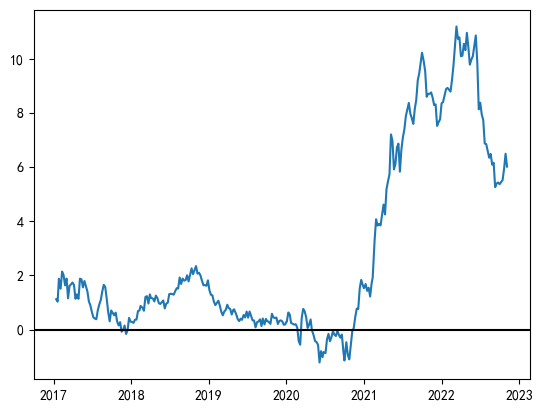

In [273]:
###选取所有期权等权重进行投资时的累计收益
plt.plot(all_end.iloc[1:,0],all_end.iloc[1:,1:].sum(axis=1))
plt.axhline(y=0, color='black', linestyle='-')

In [274]:
all_end.iloc[1:,1:].sum(axis=1)

208    1.120440
209    1.032133
210    1.874733
211    1.507429
212    2.141112
         ...   
502    5.368636
503    5.521382
504    5.931695
505    6.493356
506    6.017455
Length: 299, dtype: float64

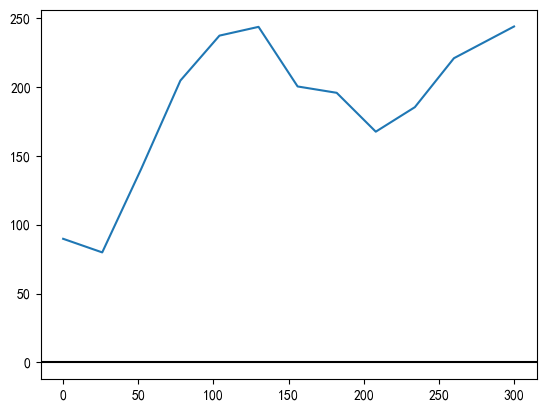

In [275]:
date_a = np.array(all_end.iloc[1:,1:].sum(axis=1))
label = [26*i for i in range(11)]
label.append(300)
date_xpl = np.zeros(12)
xpl = 0.175/2
for i in range(11):
    date_xpl[i] = date_a[:i*26+26].sum()/date_a[:i*26+26].std()
date_xpl[11] = date_a[:].sum()/date_a[:].std()
###选取所有期权等权重进行投资时的累计收益
plt.plot(label,date_xpl)
plt.axhline(y=0, color='black', linestyle='-')

画图

In [9]:
date_xpb_moment = np.c_[np.array(date_t.iloc[30:,1]),np.array(date_t.iloc[26:,1].rolling(window=4).sum()[3:-1])]

In [12]:
date_xpl = pd.DataFrame(np.zeros([len(date_t.columns),12]),columns = [i*26 for i in range(12)],index = date_t.columns)
date_moment = pd.DataFrame(np.zeros([len(date_t.columns),11]),columns = [i*26 for i in range(11)],index = date_t.columns)

In [14]:
dd = date_t.iloc[30:]
nofx_4week = 0.0175/13
for i in range(12):
    for j in range(len(date_t.columns)):
        date_xpl.iloc[j,i] = (dd.iloc[26*i:26*i+26,j].sum()-nofx_4week)/dd.iloc[26*i:26*i+26,j].std()
        # date_moment.iloc[j,i] = dd.iloc[26*i:26*i+26,j].sum()

C:\Users\lll23\AppData\Local\Temp\ipykernel_10792\2785952311.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  date_xpl.iloc[j,i] = (dd.iloc[26*i:26*i+26,j].sum()-nofx_4week)/dd.iloc[26*i:26*i+26,j].std()


In [15]:
date_xpl.replace(-np.inf, 0, inplace=True)
date_moment.replace(-np.inf, 0, inplace=True)

以周为单位的热力图

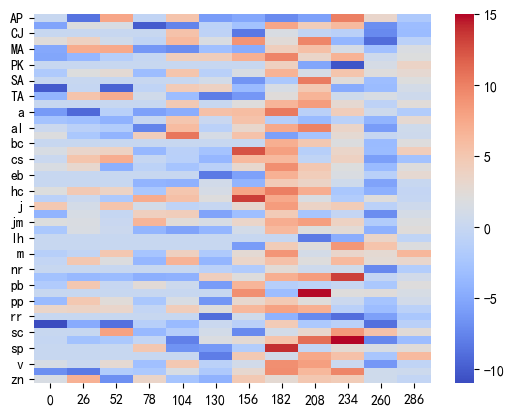

In [80]:
# 创建数据
# 绘制热力图,对于累计收益大于0的列
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题
# date_1 = date_xpl.iloc[:,:].sum()
# date_2 = date_moment.iloc[:,:].sum()
sns.heatmap((date_xpl), annot=False,cmap='coolwarm')
# plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

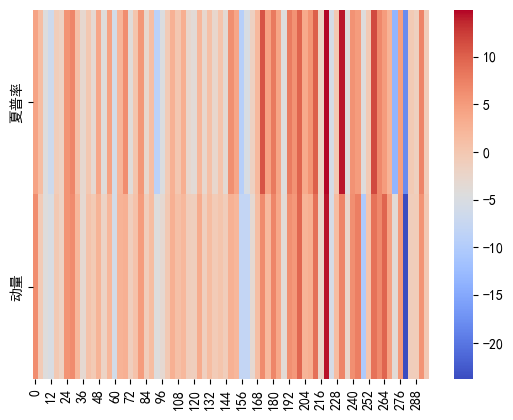

In [266]:
# 创建数据
# 绘制热力图,对于累计收益大于0的列
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题
date_1 = date_xpl.iloc[:,:].sum()
# date_2 = date_moment.iloc[:,:].sum()
sns.heatmap(pd.DataFrame([date_1/date_1.mean(),date_2/date_2.mean()],index=["夏普率","动量"]), annot=False,cmap='coolwarm')
plt.xticks(rotation=90)
plt.show()

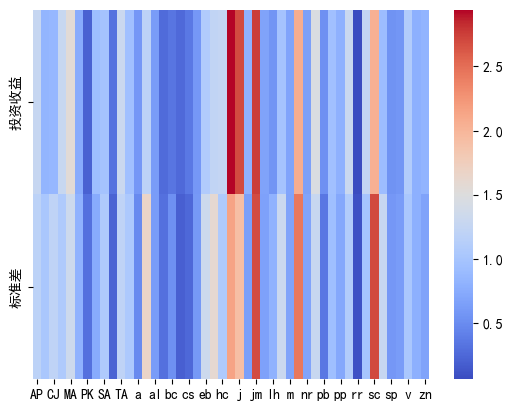

In [ ]:
# 创建数据
# 绘制热力图,对于累计收益大于0的列
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题
mmm = date_t**2
sns.heatmap(pd.DataFrame([mmm.sum()/mmm.sum().mean(),mmm.std()/mmm.std().mean()],index=["投资收益","标准差"]), annot=False,cmap='coolwarm')
plt.show()

In [27]:
label = [26*i for i in range(12)]
label.append(300)

$r_{t} - r_{t-1} $

In [40]:
###挑选所有期权,从16年下半年开始
df = date.iloc[:-1,1:]
date_t = df.iloc[181:]
date_t = date_t.fillna(0)

In [41]:
date_a = 2*np.array(date_t[:-1]) - np.array(date_t[1:])

C:\Users\lll23\AppData\Local\Temp\ipykernel_18808\983997543.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  date_xpl[i,j] = date_a[i*26:i*26+26,j].sum()-(26*xpl)/date_a[i*26:i*26+26,j].std()


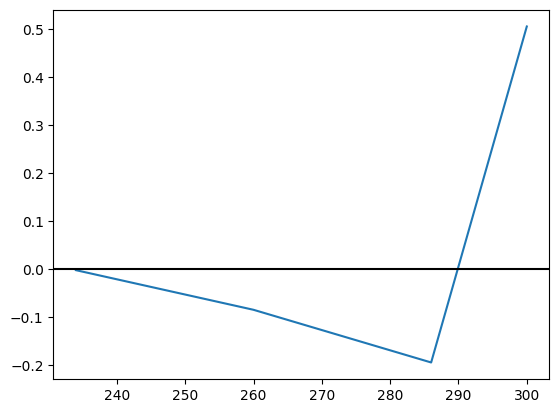

In [59]:
date_xpl = np.zeros([13,47])
xpl = 0.0175/52
for i in range(12):
    for j in range(47):
        date_xpl[i,j] = date_a[i*26:i*26+26,j].sum()-(26*xpl)/date_a[i*26:i*26+26,j].std()
for j in range(47):        
    date_xpl[12,j] = date_a[:,j].sum()-14*xpl/date_a[:,j].std()
###选取所有期权等权重进行投资时的累计收益
plt.plot(label,date_xpl.mean(axis=1))
plt.axhline(y=0, color='black', linestyle='-')

$r_{t} ^2 $

In [60]:
###挑选所有期权,从16年下半年开始
df = date.iloc[:-1,1:]
date_t = df.iloc[182:]
date_t = date_t.fillna(0)

In [72]:
date_a = np.array(date_t**2)*np.sign(np.array(date_t))+np.array(date_t)
# date_a = date_a.sum(axis=1)

C:\Users\lll23\AppData\Local\Temp\ipykernel_18808\983997543.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  date_xpl[i,j] = date_a[i*26:i*26+26,j].sum()-(26*xpl)/date_a[i*26:i*26+26,j].std()


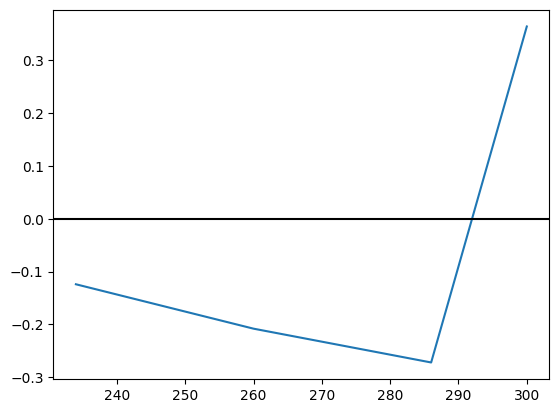

In [74]:
date_xpl = np.zeros([13,47])
xpl = 0.0175/52
for i in range(12):
    for j in range(47):
        date_xpl[i,j] = date_a[i*26:i*26+26,j].sum()-(26*xpl)/date_a[i*26:i*26+26,j].std()
for j in range(47):        
    date_xpl[12,j] = date_a[:,j].sum()-14*xpl/date_a[:,j].std()
###选取所有期权等权重进行投资时的累计收益
plt.plot(label,date_xpl.mean(axis=1))
plt.axhline(y=0, color='black', linestyle='-')

$r_t-1$

In [75]:
###挑选所有期权
df = date.iloc[:-1,1:]
date_t = df.iloc[206:-1]
date_t = date_t.fillna(0)

In [78]:
date_a = (np.array(date_t.iloc[:-1]))

C:\Users\lll23\AppData\Local\Temp\ipykernel_18808\983997543.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  date_xpl[i,j] = date_a[i*26:i*26+26,j].sum()-(26*xpl)/date_a[i*26:i*26+26,j].std()


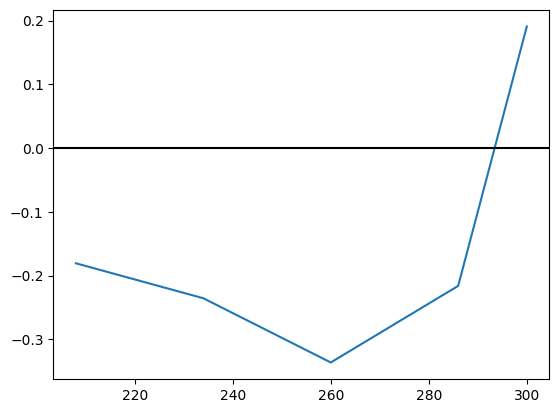

In [80]:
date_xpl = np.zeros([13,47])
xpl = 0.0175/52
for i in range(12):
    for j in range(47):
        date_xpl[i,j] = date_a[i*26:i*26+26,j].sum()-(26*xpl)/date_a[i*26:i*26+26,j].std()
for j in range(47):        
    date_xpl[12,j] = date_a[:,j].sum()-14*xpl/date_a[:,j].std()
###选取所有期权等权重进行投资时的累计收益
plt.plot(label,date_xpl.mean(axis=1))
plt.axhline(y=0, color='black', linestyle='-')

In [81]:
### momentent
date_mo = df.iloc[203:-1]
date_mo = date_mo.fillna(0)

In [83]:
date_mo = date_mo.rolling(window=4).sum().iloc[4:]

In [87]:
date_a = np.array(date_mo)

C:\Users\lll23\AppData\Local\Temp\ipykernel_18808\983997543.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  date_xpl[i,j] = date_a[i*26:i*26+26,j].sum()-(26*xpl)/date_a[i*26:i*26+26,j].std()


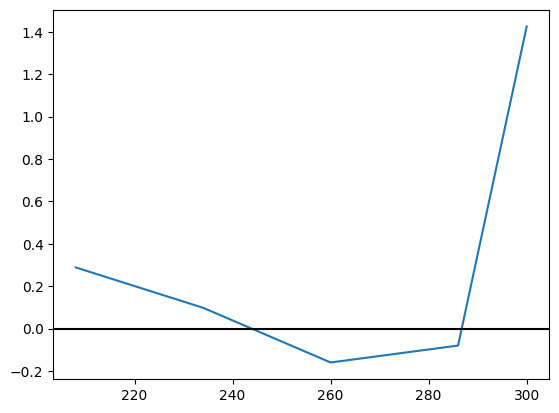

In [88]:
date_xpl = np.zeros([13,47])
xpl = 0.0175/52
for i in range(12):
    for j in range(47):
        date_xpl[i,j] = date_a[i*26:i*26+26,j].sum()-(26*xpl)/date_a[i*26:i*26+26,j].std()
for j in range(47):        
    date_xpl[12,j] = date_a[:,j].sum()-14*xpl/date_a[:,j].std()
###选取所有期权等权重进行投资时的累计收益
plt.plot(label,date_xpl.mean(axis=1))
plt.axhline(y=0, color='black', linestyle='-')